## Files are uploaded as zip, so we will unzip them first


In [ ]:
%%capture
!rm -fr /content/raw_data
!unzip /content/raw_data.zip

## Loading and preprocessing data

In [14]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import numpy as np
import torch

# Defining the path for images

high_res_dir = '/content/raw_data/high_res' 
low_res_dir = '/content/raw_data/low_res'    



class CustomDataset(Dataset):
    def __init__(self, high_res_dir, low_res_dir, transform=None):
        self.high_res_paths = [os.path.join(high_res_dir, x) for x in sorted(os.listdir(high_res_dir))]
        self.low_res_paths = [os.path.join(low_res_dir, x) for x in sorted(os.listdir(low_res_dir))]
        self.transform = transform

    def __len__(self):
        return len(self.high_res_paths)

    def __getitem__(self, idx):
        high_res_image = Image.open(self.high_res_paths[idx]).convert('RGB')
        low_res_image = Image.open(self.low_res_paths[idx]).convert('RGB')

        if self.transform:
            high_res_image = self.transform(high_res_image)
            low_res_image = self.transform(low_res_image)

        return low_res_image, high_res_image

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

dataset = CustomDataset(high_res_dir=high_res_dir, low_res_dir=low_res_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


## Ploting images from dataloader

In [ ]:
import matplotlib.pyplot as plt

# Define an inverse transform to reverse the normalization
inverse_transform = transforms.Compose([
    transforms.Normalize(mean=[0., 0., 0.], std=[1/0.229, 1/0.224, 1/0.225]),
    transforms.Normalize(mean=[-0.485, -0.456, -0.406], std=[1., 1., 1.]),
])

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')

# Retrieve a batch of images
dataiter = iter(dataloader)
images_low, images_high = next(dataiter)

# inverse transformation for visualization
images_low_inv = inverse_transform(images_low)
images_high_inv = inverse_transform(images_high)

# Display a few images from the batch
plt.figure(figsize=(20, 10))

for i in range(min(len(images_low), 4)):  # Show 4 images
    plt.subplot(2, 4, i + 1)
    imshow(images_low_inv[i])
    plt.title('Low Res')

    plt.subplot(2, 4, i + 5)
    imshow(images_high_inv[i])
    plt.title('High Res')

plt.show()


## Splitting dataloader into train, test and validation

In [17]:
from torch.utils.data.dataset import random_split

# Example dataset size and split sizes
dataset_size = len(dataset)  # instance of CustomDataset
train_size = int(0.7 * dataset_size)  # 70% of the dataset for training
val_size = int(0.15 * dataset_size)  # 15% for validation
test_size = dataset_size - train_size - val_size  # The rest for testing

# Ensuring the total size matches the dataset size
assert train_size + val_size + test_size == dataset_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [18]:
# Function to print the shape of the first batch in a DataLoader
def print_first_batch_shape(dataloader, name):
    # Fetch the first batch
    first_batch = next(iter(dataloader))
    inputs, targets = first_batch

    print(f"{name} DataLoader - Input batch shape: {inputs.shape}, Target batch shape: {targets.shape}")

# Print shapes for train, validation, and test DataLoaders
print_first_batch_shape(train_loader, "Train")
print_first_batch_shape(val_loader, "Validation")
print_first_batch_shape(test_loader, "Test")


Train DataLoader - Input batch shape: torch.Size([32, 3, 256, 256]), Target batch shape: torch.Size([32, 3, 256, 256])
Validation DataLoader - Input batch shape: torch.Size([32, 3, 256, 256]), Target batch shape: torch.Size([32, 3, 256, 256])
Test DataLoader - Input batch shape: torch.Size([32, 3, 256, 256]), Target batch shape: torch.Size([32, 3, 256, 256])


## Define the model

In [19]:
import torch.nn as nn
import torch.nn.functional as F

class SRCNN(nn.Module):
    def __init__(self):
        super(SRCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=9, padding=4)
        self.conv2 = nn.Conv2d(64, 32, kernel_size=1)
        self.conv3 = nn.Conv2d(32, 3, kernel_size=5, padding=2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.conv3(x)
        return x

model = SRCNN()

## Generate Architecture diagram

In [20]:
%%capture
pip install torchviz

In [21]:
import torch
from torchviz import make_dot

def plot_model(model, input_size):
    """
    Function to plot the PyTorch model using torchviz.

    Parameters:
    - model: The PyTorch model to visualize.
    - input_size: Size of the input tensor (excluding batch size).
    """
    # dummy input tensor appropriate for the model
    dummy_input = torch.randn(1, *input_size, dtype=torch.float)

    # forward pass to get the output
    output = model(dummy_input)

    # torchviz to create a dot graph of the model
    dot = make_dot(output, params=dict(list(model.named_parameters())))

    # Render the dot graph to a file (or display it in some environments)
    dot.render("model_visualization", format="png", cleanup=True)
    print("Model plot saved as model_visualization.png")


In [26]:
from torchviz import make_dot
import os
os.environ["PATH"] += os.pathsep + r"C:\Program Files (x86)\Graphviz-10.0.1-win64\bin"

model = SRCNN()  
print(model)
plot_model(model, input_size=(3, 256, 256))

SRCNN(
  (conv1): Conv2d(3, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
  (conv2): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
  (conv3): Conv2d(32, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
)
Model plot saved as model_visualization.png


## Train model

cpu
Epoch 1, Training Loss: 0.49459032400658254
Epoch 1, Validation Loss: 0.1970447152853012
Epoch 2, Training Loss: 0.1620581777472245
Epoch 2, Validation Loss: 0.14993614330887794
Epoch 3, Training Loss: 0.1177511928897155
Epoch 3, Validation Loss: 0.11169746704399586
Epoch 4, Training Loss: 0.08668415326821177
Epoch 4, Validation Loss: 0.08511955849826336
Epoch 5, Training Loss: 0.07142116992097151
Epoch 5, Validation Loss: 0.07576286792755127
Epoch 6, Training Loss: 0.06332706326716825
Epoch 6, Validation Loss: 0.06730292830616236
Epoch 7, Training Loss: 0.05701659443347078
Epoch 7, Validation Loss: 0.06065546069294214
Epoch 8, Training Loss: 0.051946519236815605
Epoch 8, Validation Loss: 0.057433830574154854
Epoch 9, Training Loss: 0.048862184348859285
Epoch 9, Validation Loss: 0.050916231237351894
Epoch 10, Training Loss: 0.04376938801847006
Epoch 10, Validation Loss: 0.04821980558335781
Epoch 11, Training Loss: 0.04116602340026906
Epoch 11, Validation Loss: 0.04489726014435291
E

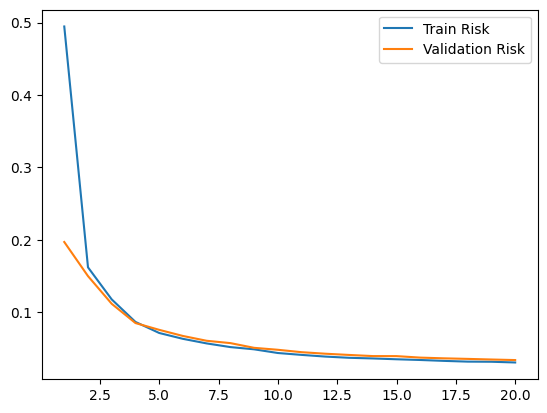

In [27]:
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model = model.to(device)

# set loss to MSE
loss_function = nn.MSELoss()

# Set optimizer as Adam
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Number of epochs
epochs = 20

# Initiate the values
train_risk = []
val_risk = []

for epoch in range(epochs):
    # Training loop
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(inputs)

        # Calculate loss
        loss = loss_function(outputs, labels)
        running_loss += loss.item()

        # Zero the parameter gradients
        optimizer.zero_grad()
        # Backward pass and optimize
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch+1}, Training Loss: {running_loss/len(train_loader)}')

    # Validation loop
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            val_loss += loss.item()

    train_risk.append(running_loss/len(train_loader))
    val_risk.append(val_loss/len(val_loader))
    print(f'Epoch {epoch+1}, Validation Loss: {val_loss/len(val_loader)}')


# plot the losses
plt.plot([i+1 for i in range(epochs)], train_risk, label='Train Risk')
plt.plot([i+1 for i in range(epochs)], val_risk, label='Validation Risk')
plt.legend()
plt.show()

## Test Loop

In [11]:
%%capture
pip install pytorch-msssim

## Metrics

In [ ]:
import torch
import numpy as np
from math import log10
from pytorch_msssim import ssim 
import matplotlib.pyplot as plt
import random
from skimage.metrics import structural_similarity as ssim

def psnr(target, prediction):
    mse = torch.mean((target - prediction) ** 2)
    return 20 * torch.log10(1.0 / torch.sqrt(mse))
model.eval()
total_psnr = 0.0
total_mse = 0.0
total_ssim = 0.0
total_samples = 0
images_displayed = []  # Number of batches to display
total_psnr_ = 0
count = 0
with torch.no_grad():
    for batch_idx, (inputs, labels) in enumerate(test_loader):
            print(f"batch_idx: {batch_idx}")
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            total_samples += inputs.size(0)
            print(f"total_samples: {total_samples}")
            for j in range(min(inputs.size(0), 5)):
                i = random.randrange(0, inputs.size(0))
                if i in images_displayed:
                    continue
                else:
                    images_displayed.append(i)
                    print(f"i: {i}")

                    # Move images back to CPU for visualization
                    inputs, labels, outputs = inputs.cpu(), labels.cpu(), outputs.cpu()
                    mse_value = torch.mean((outputs[i] - labels[i]) ** 2)
                    total_psnr = psnr(labels[i], outputs[i])
                    

                    # SSIM calculation
                    y_true_np = labels[i].cpu().numpy()
                    y_pred_np = outputs[i].cpu().numpy()

                    # SSIM expects images in the format (Height, Width, Channels)
                    y_true_np = np.transpose(y_true_np, (1, 2, 0))
                    y_pred_np = np.transpose(y_pred_np, (1, 2, 0))

                    # Calculate SSIM
                    ssim_index = ssim(y_true_np, y_pred_np, data_range=1, channel_axis=2)
                    
                    # Apply the inverse transformation for visualization
                    images_low_inv = inverse_transform(inputs[i])
                    images_high_inv = inverse_transform(labels[i])
                    outputs_inv = inverse_transform(outputs[i])
                    images_low_inv = torch.clamp(images_low_inv, 0, 1)
                    images_high_inv = torch.clamp(images_high_inv, 0, 1)
                    outputs_inv = torch.clamp(outputs_inv, 0, 1) # Apply inverse transform to model outputs

                    # Display images
                    plt.figure(figsize=(30,30))
                    # Display high-resolution target images
                    plt.subplot(1,3,1)
                    imshow(images_high_inv)
                    plt.title('High-Res Target')

                    # Display low-resolution images
                    plt.subplot(1,3,2)
                    imshow(images_low_inv)
                    plt.title('Low-Res Input')

                    # Display the model's output images
                    plt.subplot(1,3,3)
                    imshow(outputs_inv)
                    plt.title('Model Output')
                    # plot_images(images_high_inv[i],images_low_inv[i],outputs_inv[i])
                    plt.show()

                    

                    print(f'MSE: {mse_value}')
                    print(f'PSNR: {total_psnr} dB')
                    print(f'SSIM: {ssim_index}')
                    count += 1
                    
                    total_mse += mse_value
                    total_psnr_ += total_psnr
                    total_ssim += ssim_index
                    
average_mse = total_mse / count
average_psnr = total_psnr_ / count
average_ssim = total_ssim / count

print(f'\n\nAverage Test MSE: {average_mse}')
print(f'\n\nAverage Test PSNR: {average_psnr}')
print(f'\n\nAverage Test SSIM: {average_ssim}')
